# EDAV Project: Yelp Restaurants Reviews

Rui Wen (rw2648)

## Introduction

This project will attempt to use data visualization techniques to find out what factors leads to high Yelp reviews for restaurants. This general question is very relatable to many people as the Yelp rating is usually a good indicator of the experience at a new restaurant. It helps us make informed decision on that nervous first date, that large family gathering, or that 3 a.m. pizza run in the morning last Saturday. Hopefully, the results will not only help the consumers from understanding what makes a restaurant popular, but also help restaurant owners understand how they can improve their Yelp ratings and customer satisfaction.

## Team

 I am working on my own for this project.

## Analysis of Data Quality

This dataset is part of a Yelp data competition. It can be downloaded for free after submitting your name and email at:

https://www.yelp.com/dataset_challenge/dataset

This analysis is not done for the competition. It is merely using the publicly available data. In fact, the competition would require lots of machine learning and predictive analysis. The data comes in a zip file, and it includes several data sets. For the scope for this project, only the datasets containing the data for businesses and their lists of reviews will be used.

In [8]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#load the json file and pull out all busineses listed as retaurants
with open("yelp/yelp_academic_dataset_business.json") as data_file:   
    data = data_file.readlines()
    data_json_str = "[" + ','.join(data) + "]"
business = pd.read_json(data_json_str)
def get_rest(r):
    try:
        return "Restaurants" in r["categories"]
    except:
        return False
restaurants = business.loc[business.apply(get_rest,axis=1),:]

There are around 50,000 restaurants to work with after filtering. Here's a sample of the restaurants dataset. 

In [115]:
print restaurants.shape
restaurants.head(3)

(48485, 64)


,business_id,city,is_open,name,review_count,stars,state,Nightlife,Bars,American (Traditional),...,touristy,trendy,upscale,casual,dessert,latenight,lunch,dinner,breakfast,brunch
2,EDqCEAGXVGCH4FJXgqtjqg,Toronto,1,Pizza Pizza,7,2.5,ON,0,0,0,...,False,False,False,False,False,False,False,False,False,False
7,GDnbt3isfhd57T1QqU6flg,Scottsdale,1,Taco Bell,9,2.5,AZ,0,0,0,...,False,False,False,False,False,False,False,False,False,False
11,42romV8altAeuZuP2OC1gw,Henderson,0,Ohana Hawaiian BBQ,38,4.0,NV,0,0,0,...,False,False,False,True,False,False,True,True,False,False


There's a lot of columns that will not be used for analysis. The important features that will be used are attributes, categories, review count, and stars.

It's important to note that these restaurants are not evenly pulled from the general U.S. geographic region. In fact, a graph of the state column shows that the dataset consists of restaurants from several specific states, such as ON (Canada), AZ, NV, and OH. However, this should not affect the analysis that will be done in this paper.

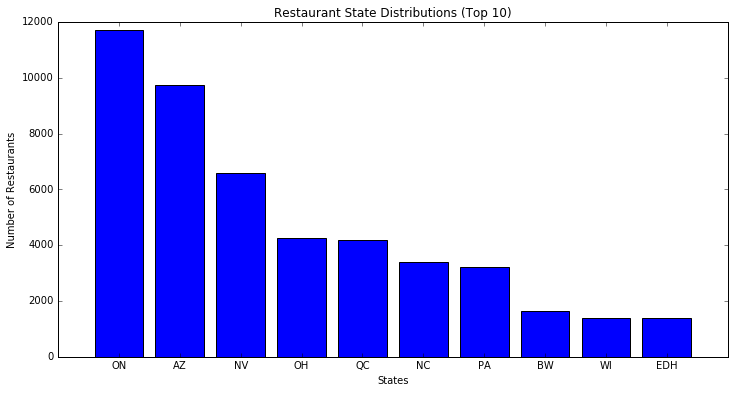

In [70]:
counts = restaurants.state.value_counts()[:10]
plt.figure(figsize=(12, 6))
plt.bar(range(1,len(counts.index)+1),counts.values,align="center")
plt.xticks(range(1,len(counts.index)+1), counts.index)
plt.xlabel("States")
plt.ylabel("Number of Restaurants")
plt.xlim((0,11))
plt.title("Restaurant State Distributions (Top 10)")
plt.show()

Three out of the four features that will be used for analysis have no missing values. The attributes column has 897 missing values, but that's trivial compare to the number of rows in the data set. Those rows can simply be ignored when the attribute field is analyzed.


In [73]:
print "Number of Null Values in Stars: %s" % restaurants.stars.isnull().sum()
print "Number of Null Values in Review Counts: %s" % restaurants.review_count.isnull().sum()
print "Number of Null Values in Categories: %s" % restaurants.categories.isnull().sum()
print "Number of Null Values in Attributes: %s" % restaurants.attributes.isnull().sum()

Number of Null Values in Stars: 0
Number of Null Values in Review Counts: 0
Number of Null Values in Categories: 0
Number of Null Values in Attributes: 897


The data looks complete based on the above analysis. However, there's some preprocessing that needs to be done for both the categories and the attribute field for them to be useful in analysis.

Below is a print out of the category field for the first 15 entries. Each restaurant can have multiple labels in their category list, which describes the type of restaurant it is. These categories are also not mutually exclusive. A restaurant can have multiple labels at a time. This information will be recoded as columns with indicator variables, indicating whether a specific restaurant has that category label. For analysis purpose, the number of columns created by this process will be capped at 30, ranked by the frequency of the category label among the entire dataset.


In [79]:
restaurants.categories.iloc[:15]

2          [Restaurants, Pizza, Chicken Wings, Italian]
7            [Tex-Mex, Mexican, Fast Food, Restaurants]
11                    [Hawaiian, Restaurants, Barbeque]
21                                 [Restaurants, Cafes]
23    [Sandwiches, Breakfast & Brunch, Salad, Restau...
25                    [Fast Food, Mexican, Restaurants]
29                      [Restaurants, Italian, Seafood]
32       [Restaurants, Mexican, American (Traditional)]
33          [Restaurants, Waffles, Southern, Soul Food]
37    [Persian/Iranian, Restaurants, Ethnic Food, Fo...
39                [American (Traditional), Restaurants]
40                                  [Thai, Restaurants]
41                               [Tex-Mex, Restaurants]
43        [Breakfast & Brunch, Sandwiches, Restaurants]
44    [American (New), Pubs, Nightlife, Bars, Restau...
Name: categories, dtype: object

These are the top 30 category labels.

In [82]:
cat = np.apply_along_axis(lambda r:np.array(r),0,restaurants["categories"])
flat_cat = np.concatenate(cat,0)
flat_ser = pd.Series(flat_cat)
top_cat = flat_ser.value_counts()[2:32]
top_cat_names = top_cat.index
for n in top_cat_names:
    print n

Nightlife
Bars
American (Traditional)
Fast Food
Pizza
Sandwiches
Italian
Burgers
Mexican
American (New)
Chinese
Breakfast & Brunch
Cafes
Coffee & Tea
Japanese
Chicken Wings
Seafood
Sushi Bars
Event Planning & Services
Delis
Asian Fusion
Salad
Mediterranean
Sports Bars
Canadian (New)
Barbeque
Steakhouses
Indian
Thai
Specialty Food


In [83]:
#add binary columsn for top 30 categories 
for t in top_cat_names:
    restaurants[t]=restaurants.apply(lambda r: 1 if t in r["categories"] else 0,axis=1)   

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


The attribute column is a bit more complicated. It's has many fields within each cell value. Labels such as "Ambience" and "Good For Meals" has yet another layer of information, encoded as a dictionary. The same method is used here to create individual indicator columns for these attributes. Only attributes that are included in more 50% of the entries are converted to columns.

In [87]:
restaurants.attributes[2]

[u'Alcohol: none',
 u"Ambience: {'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}",
 u'BikeParking: True',
 u'BusinessAcceptsCreditCards: True',
 u"BusinessParking: {'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}",
 u'Caters: True',
 u'GoodForKids: True',
 u"GoodForMeal: {'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'breakfast': False, 'brunch': False}",
 u'HasTV: True',
 u'NoiseLevel: quiet',
 u'OutdoorSeating: False',
 u'RestaurantsAttire: casual',
 u'RestaurantsDelivery: True',
 u'RestaurantsGoodForGroups: True',
 u'RestaurantsPriceRange2: 1',
 u'RestaurantsReservations: False',
 u'RestaurantsTableService: False',
 u'RestaurantsTakeOut: True',
 u'WiFi: free']

The top 18 attributes are listed below. 

In [84]:
#find top 18 attributes that are labled 
#all of these have more than 50% availbility filled out 
def process_att(r):
    if r is not None:
        return np.array(map(lambda e: e.split(":")[0],r))
    return np.array([])
att = np.array(restaurants["attributes"].apply(process_att))
flat_att = pd.Series(np.concatenate(att,0))
top_att = flat_att.value_counts()[2:19]
top_att_names = top_att.index
for att in top_att_names:
    print att

RestaurantsTakeOut
RestaurantsGoodForGroups
GoodForKids
RestaurantsAttire
RestaurantsReservations
RestaurantsDelivery
OutdoorSeating
GoodForMeal
BusinessParking
HasTV
Alcohol
RestaurantsTableService
Ambience
NoiseLevel
WiFi
BikeParking
Caters


In [85]:
#add column attributes to data set 
def add_att(r,at):
    if r is not None:
        for e in r:
            h,t = e.split(": ",1)
            if at == h:
                return t
        return None
    else:
        return None
        
for at in top_att_names:
    if at not in ["BusinessParking","BikeParking","Ambience","GoodForMeal"]:
        restaurants[at]=restaurants.apply(lambda r: add_att(r["attributes"],at),1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


As shown above, the ambience and the good for meals label needs additional unwrapping. This is done below with two separate functions.

In [88]:
def process_ambience(att):
    if att is not None:
        for at in att:
            h,t = at.split(": ",1)
            if h=="Ambience":
                values = []
                for l in t.strip("{}").split(", "):
                    if l.split(": ")[0]!="'divey'":
                        values.append(l.split(": ")[1])
                return pd.Series(values)
    return pd.Series([None,None,None,None,None,None,None,None])

ambience_cols = restaurants.attributes.apply(lambda r:process_ambience(r))
ambience_cols.columns = ['romantic', 'intimate', 'classy','hipster','touristy','trendy','upscale','casual']
restaurants = restaurants.join(ambience_cols)

In [89]:
def process_meal(att):
    if att is not None:
        for at in att:
            h,t = at.split(": ",1)
            if h=="GoodForMeal":
                values = []
                for l in t.strip("{}").split(", "):
                    values.append(l.split(": ")[1])
                return pd.Series(values)
    return pd.Series([None,None,None,None,None,None])

meal_cols = restaurants.attributes.apply(lambda r:process_meal(r))
meal_cols.columns = ['dessert', 'latenight', 'lunch','dinner','breakfast','brunch']
restaurants = restaurants.join(meal_cols)

Now with all the category and attributes variables encoded as binary indicators, they can be easily accessed for plotting and analysis in the later sections. Even though not every restaurant has every label filled out, it will not hinder the analysis since the data set is quite large and only the top categorical and attribute labels were chosen to be converted to binary columns. Finally, the columns that will not be used for analysis will be dropped.

In [92]:
restaurants.drop(["address",
                  "attributes",
                  "categories",
                  "hours",
                  "latitude",
                  "longitude",
                  "neighborhood",
                  "postal_code",
                  "type"],axis=1,inplace=True)

restaurants.to_csv("rest_processed.csv",encoding="utf-8")

# Executive Summary

The focus of this analysis is on the ratings or stars that the restaurants receive. It explores the relationship between ratings and three key variables, Review Counts, Categories, and Attributes. A large portion of the analysis was done on the labels that are extracted from the latter two variables. In addition, basic text analytics was performed on a sample of the user reviews. The analysis is broken down as follows:
- Basic Analysis on Distribution of Ratings and Review Count (Executive Summary)
- Categories Drill Down (Main Analysis)
- Attributes Drill Down (Main Analysis)
- User Reviews Text Analytics (Main Analysis)

### Ratings and Review Counts

The following histogram shows the distribution of the ratings of every restaurant in the data set and the corresponding median review count for each rating group. 

Note: Plots in the remaining report will be generated via Tableau.

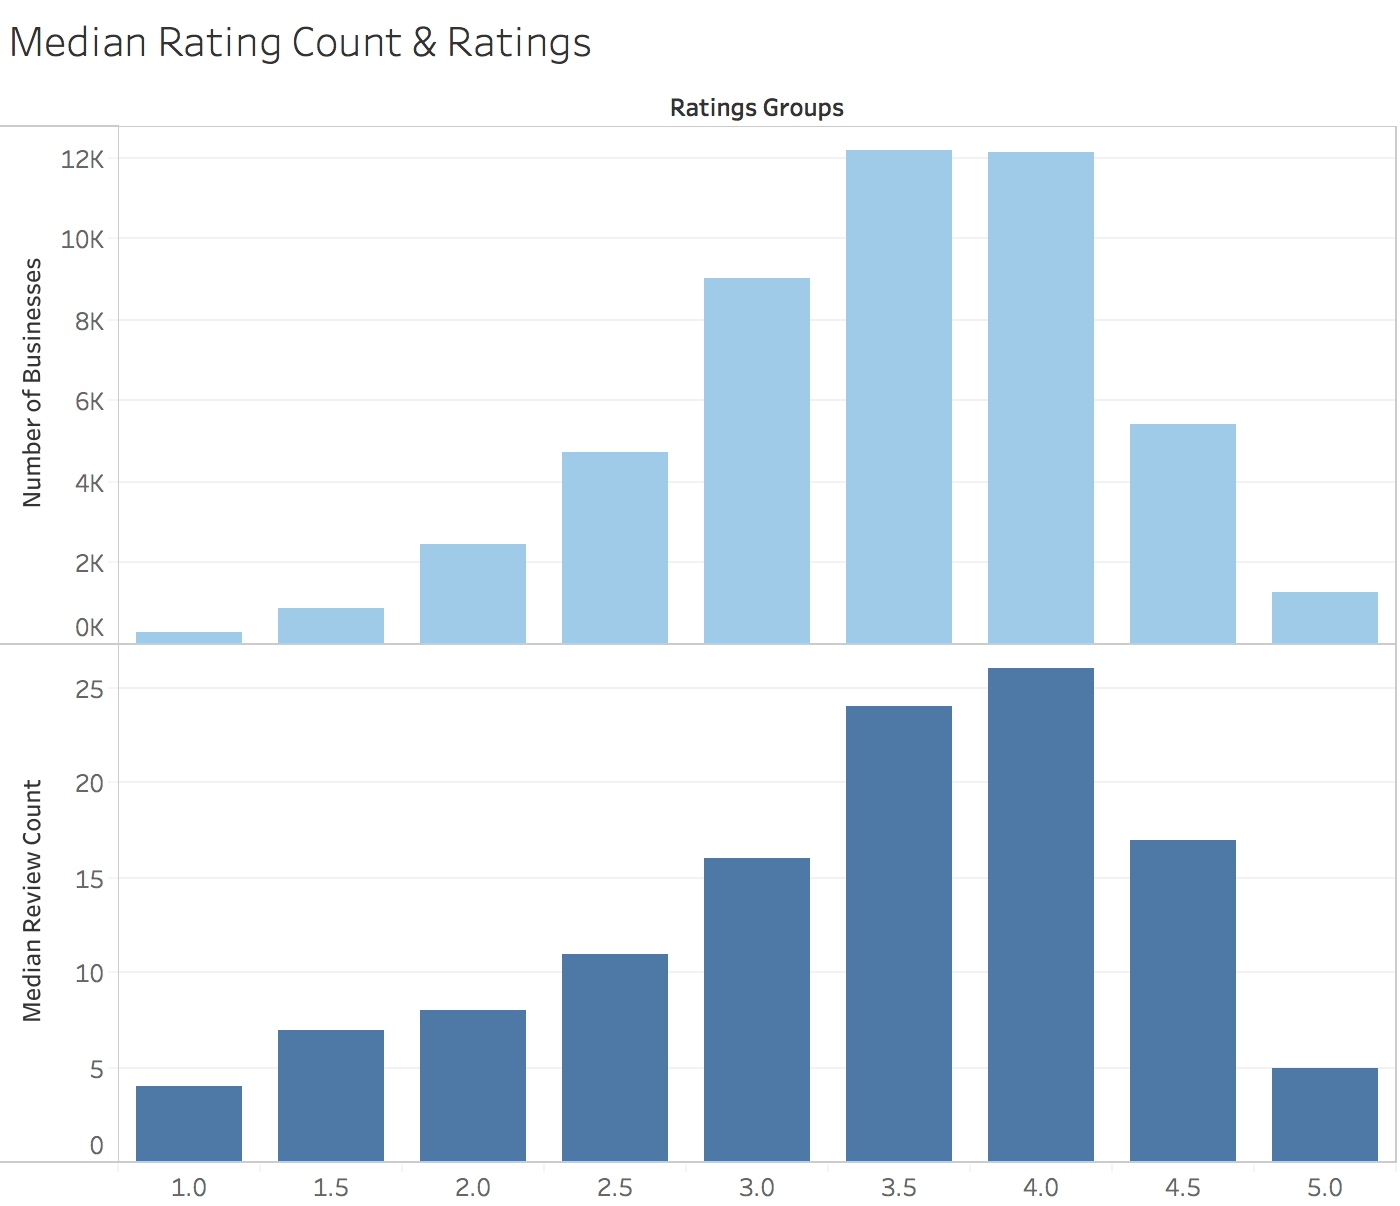

In [2]:
from IPython.display import Image
Image(filename='yelp/Review Count & Ratings.png',width=600,height=400)

The histogram for the restaurant ratings looks smooth. It has a bell shape with a skewed left tail. The median is around 3.5 to 4 stars. This is not surprising based on personal experience with the Yelp app. Most the restaurants has a rating that falls between 3 and 4.5 stars, while a small number of them has a perfect 5-star rating. The lowly rated restaurants are spread out among the lower ratings ranges. Even though this histogram corresponds with the general expectation, it does beg the question why the median is not centered near the middle of the entire ratings range at 3 stars. This pattern indicates that people are generally "nice" or even "too nice" when it comes to giving ratings. Unless someone encounters a bad experience with the restaurant, he will usually give a score near 3.5 or 4 stars, instead of 3. A restaurant with a 4-star rating is in fact considered average relative to the entire data set. The score of 4/5, which implies above-average experience, is somewhat misleading. This maybe just a flaw with the 5-star rating system that's not unique to just Yelp reviews. 

Below the axis is the median review count for each of these rating groups. Interestingly, the shape is very similar. The groups with high median reviews are, again, around 3.5 - 4.5. This shows that that after a restaurant accumulates enough reviews, its rating tends to average out to the center of the rating distribution. The median rating for the 5-star group is very low. This is expected, as it's hard to keep a perfect score once reviews accumulate. Even though the median review count for any groups is not very high, there are many outlier restaurants that have review counts up to the thousands. This reflects how popularity can drive traffic and business growth at a exponential rate. The graph below shows those outliers.

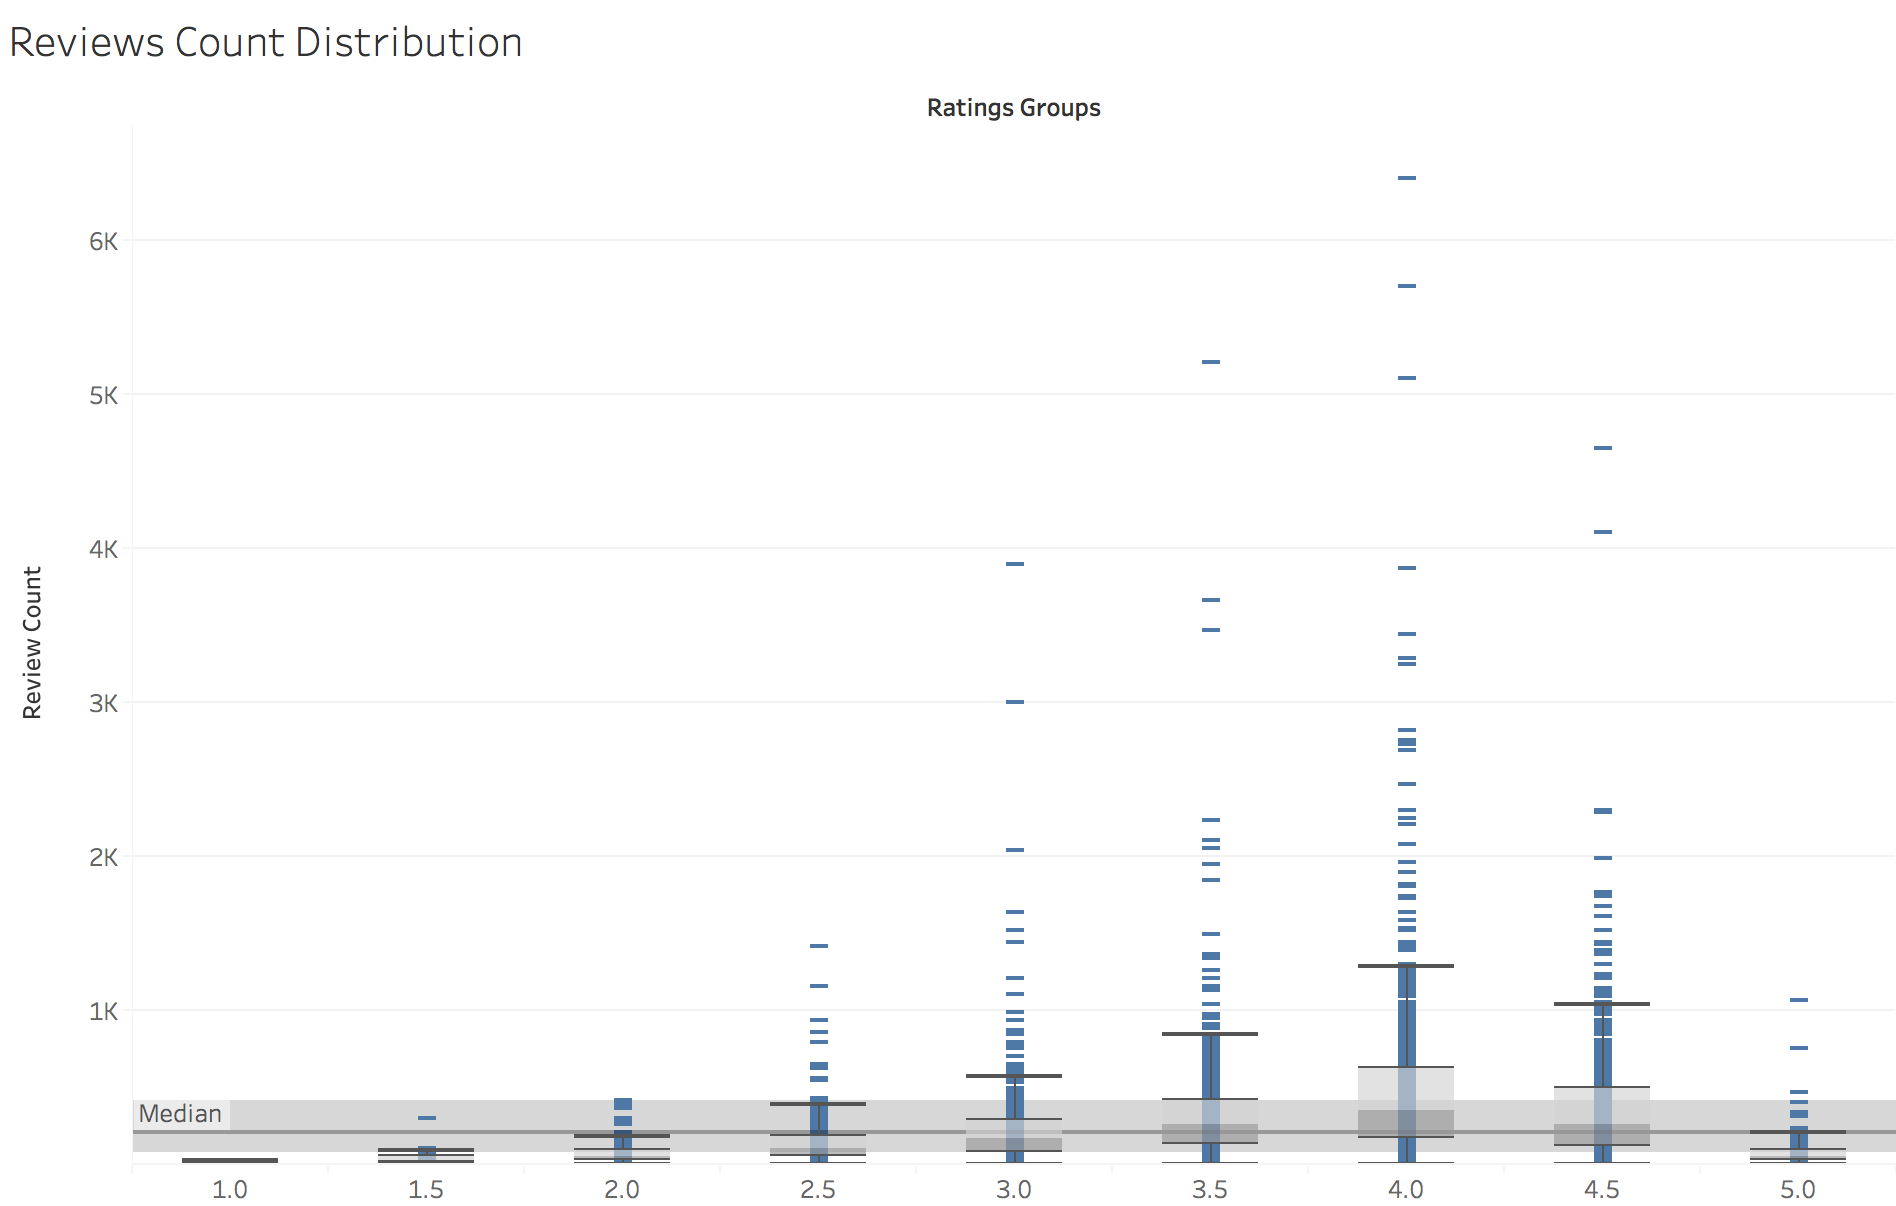

In [145]:
Image(filename='yelp/Reviews Count Distribution.png',width=700,height=500)


### Categories

Each restaurant is also labeled with multiple category labels, that describes the type of food they serve or the type of restaurant they operate as. With some simple grouping and sorting, the following plot answers what type of restaurant, in average, receives higher ratings. 

In [111]:
def get_avg_rating(cat):
    return restaurants["stars"].loc[restaurants[cat]==1].mean()
top_20 = pd.Series(top_cat_names)
avg_ratings = top_20.apply(get_avg_rating)
cat_rat = pd.DataFrame([top_20,avg_ratings]).T
cat_rat.columns = ["Category","Average Rating"]
cat_rat.to_csv("cat_rat.csv",encoding="utf-8")

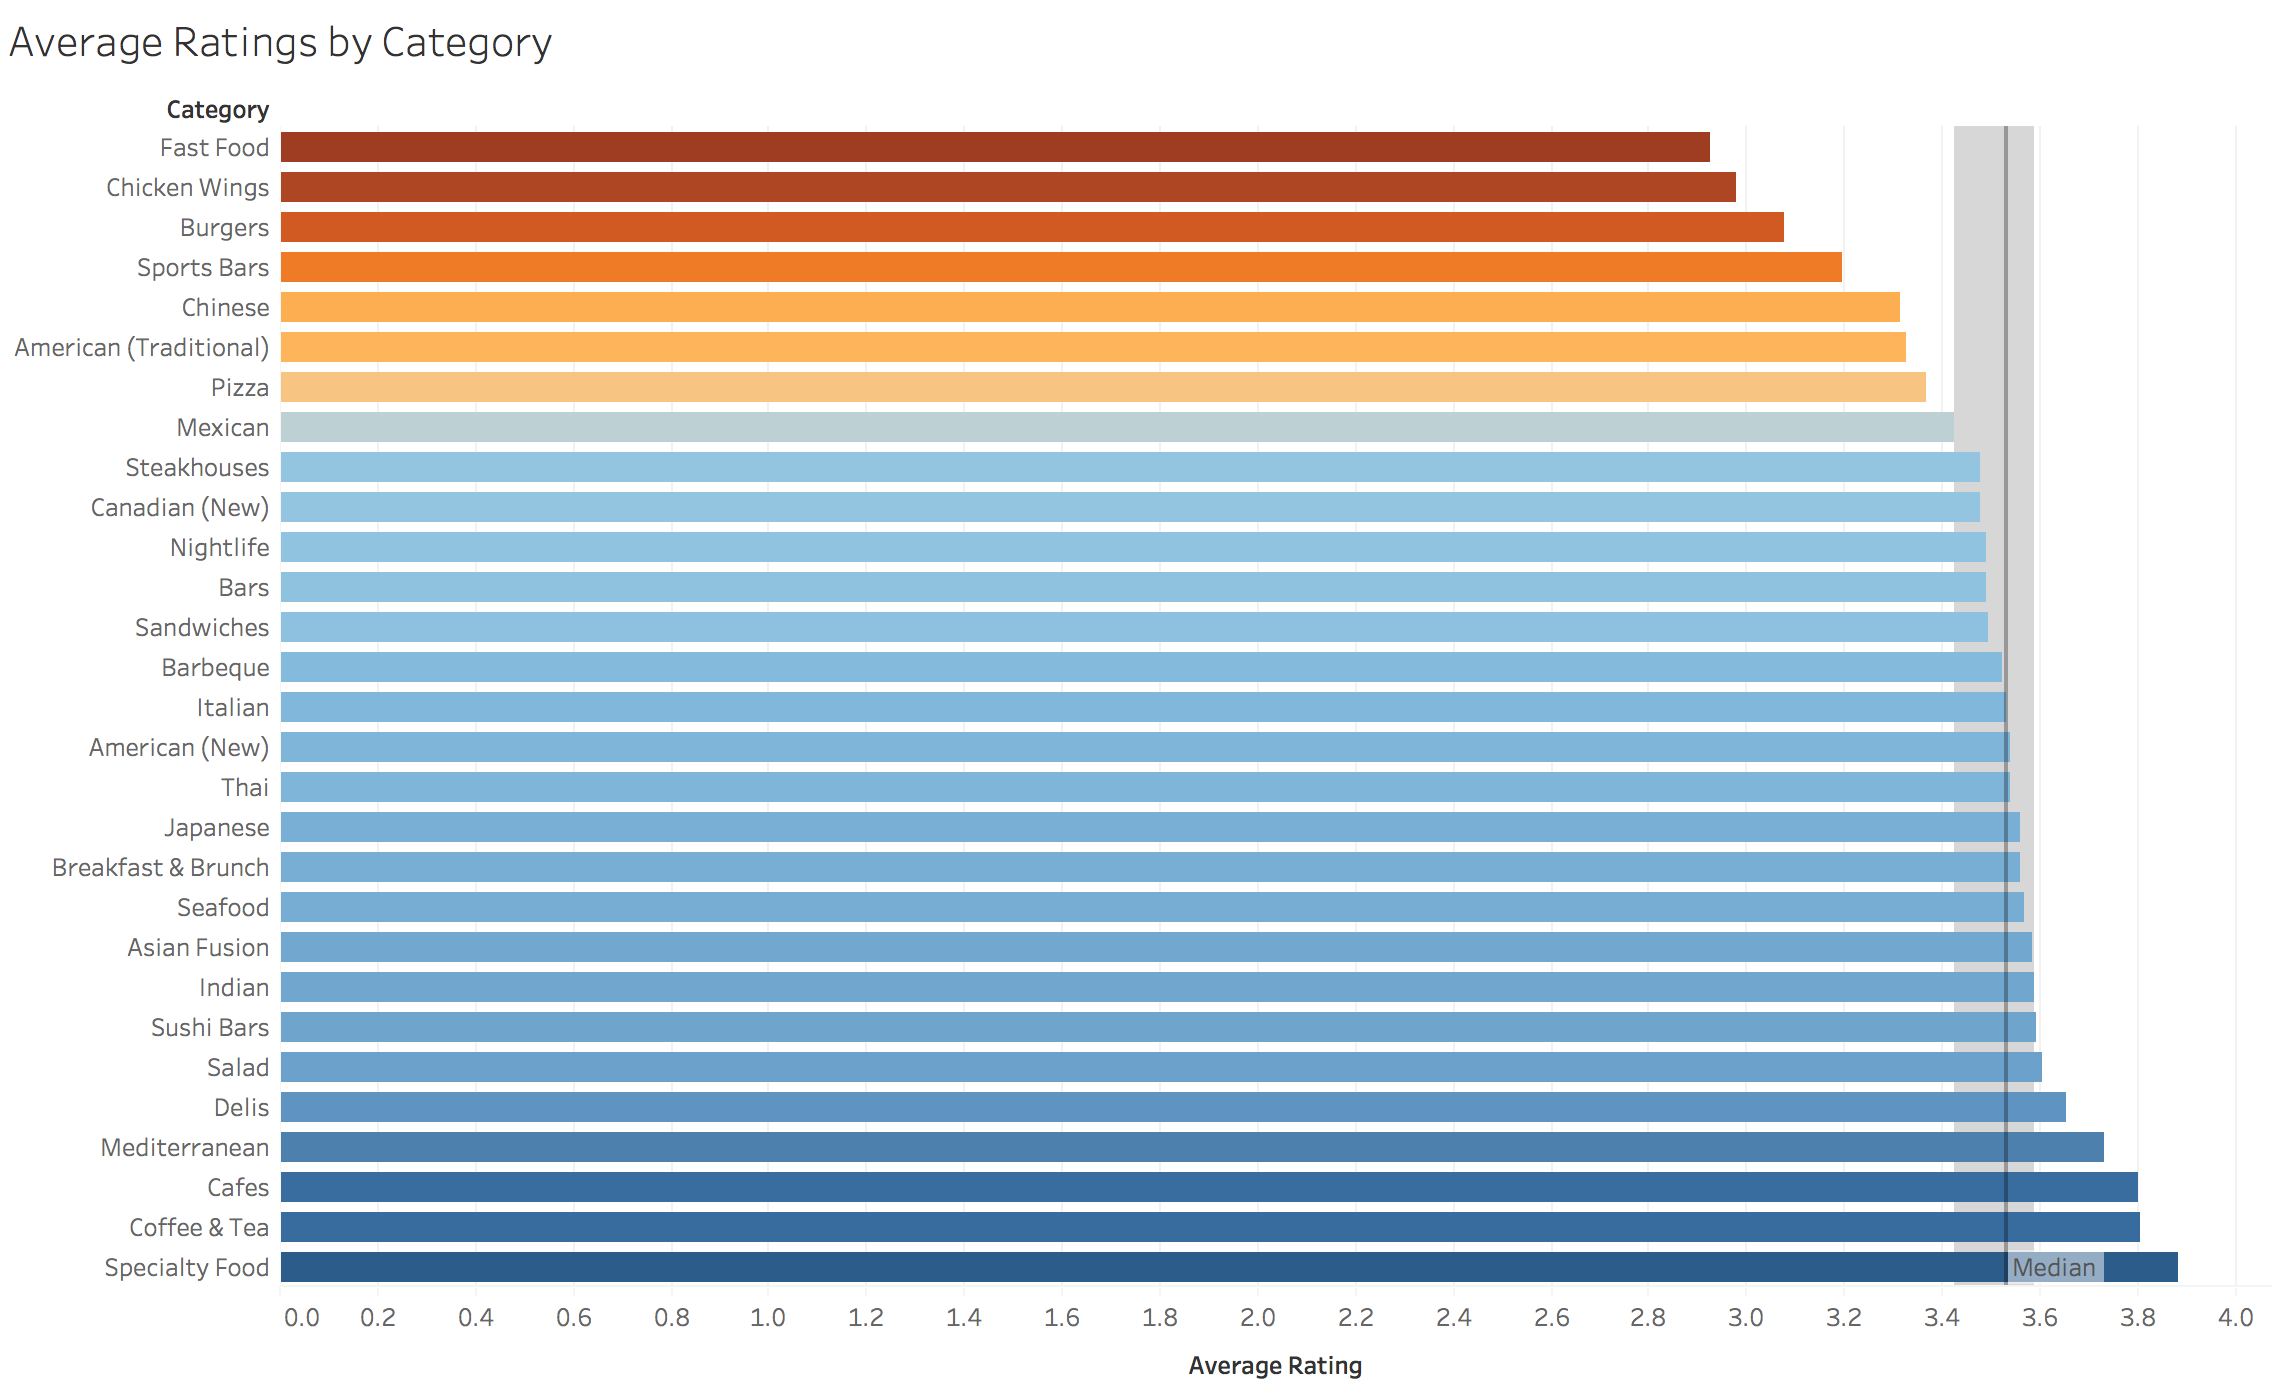

In [142]:
Image(filename='yelp/ratings_by_cat.png',width=800,height=600)

There's a pretty clear relationship between ratings and restaurant categories. Unhealthy labels such as Fast Food, Chicken Wings, and Burgers has the lower average ratings. Fast food restaurants has the lowest average rating of 2.9, which is probably due to poor service and low quality food. Overall, most of the labels with average ratings below the median are associated with poor service and unhealthy options. On the other end of the spectrum, the labels with the higher average ratings such as Salad, Mediterranean, and Sushi Bars are associated with healthy food choices. An exception is that the labels Cafes and Coffee & Tea has higher average ratings than any other restaurant labels. Customers are usually easily satisfied when they're just grabbing a coffee or a pastry instead of eating an entire meal. There's more room for dissatisfaction and error. In the main analysis section, the distribution of ratings among the highly and lowly rated labels will be further explored.

### Attributes

There are many more attributes than categories, so only selected groups of attributes were analyzed in response to restaurant ratings. Attributes that are related are grouped together and plotted with ratings in the main analysis section to answer specific questions. The groups are as follow, with the selected attributes in parentheses:
- Fancy Restaurants (Trendy, Accept Reservations, Restaurant Attire, Upscale)
- Restaurant Accommodation (Good for Kids, Has TV, Outdoor Seating, Good for Groups)
- A Night Out (Nightlife, Alcohol, Noise Level)


## Main Analysis

### Category Labels with Low Ratings

The following plot shows the distribution of restaurant ratings associated with low rating labels


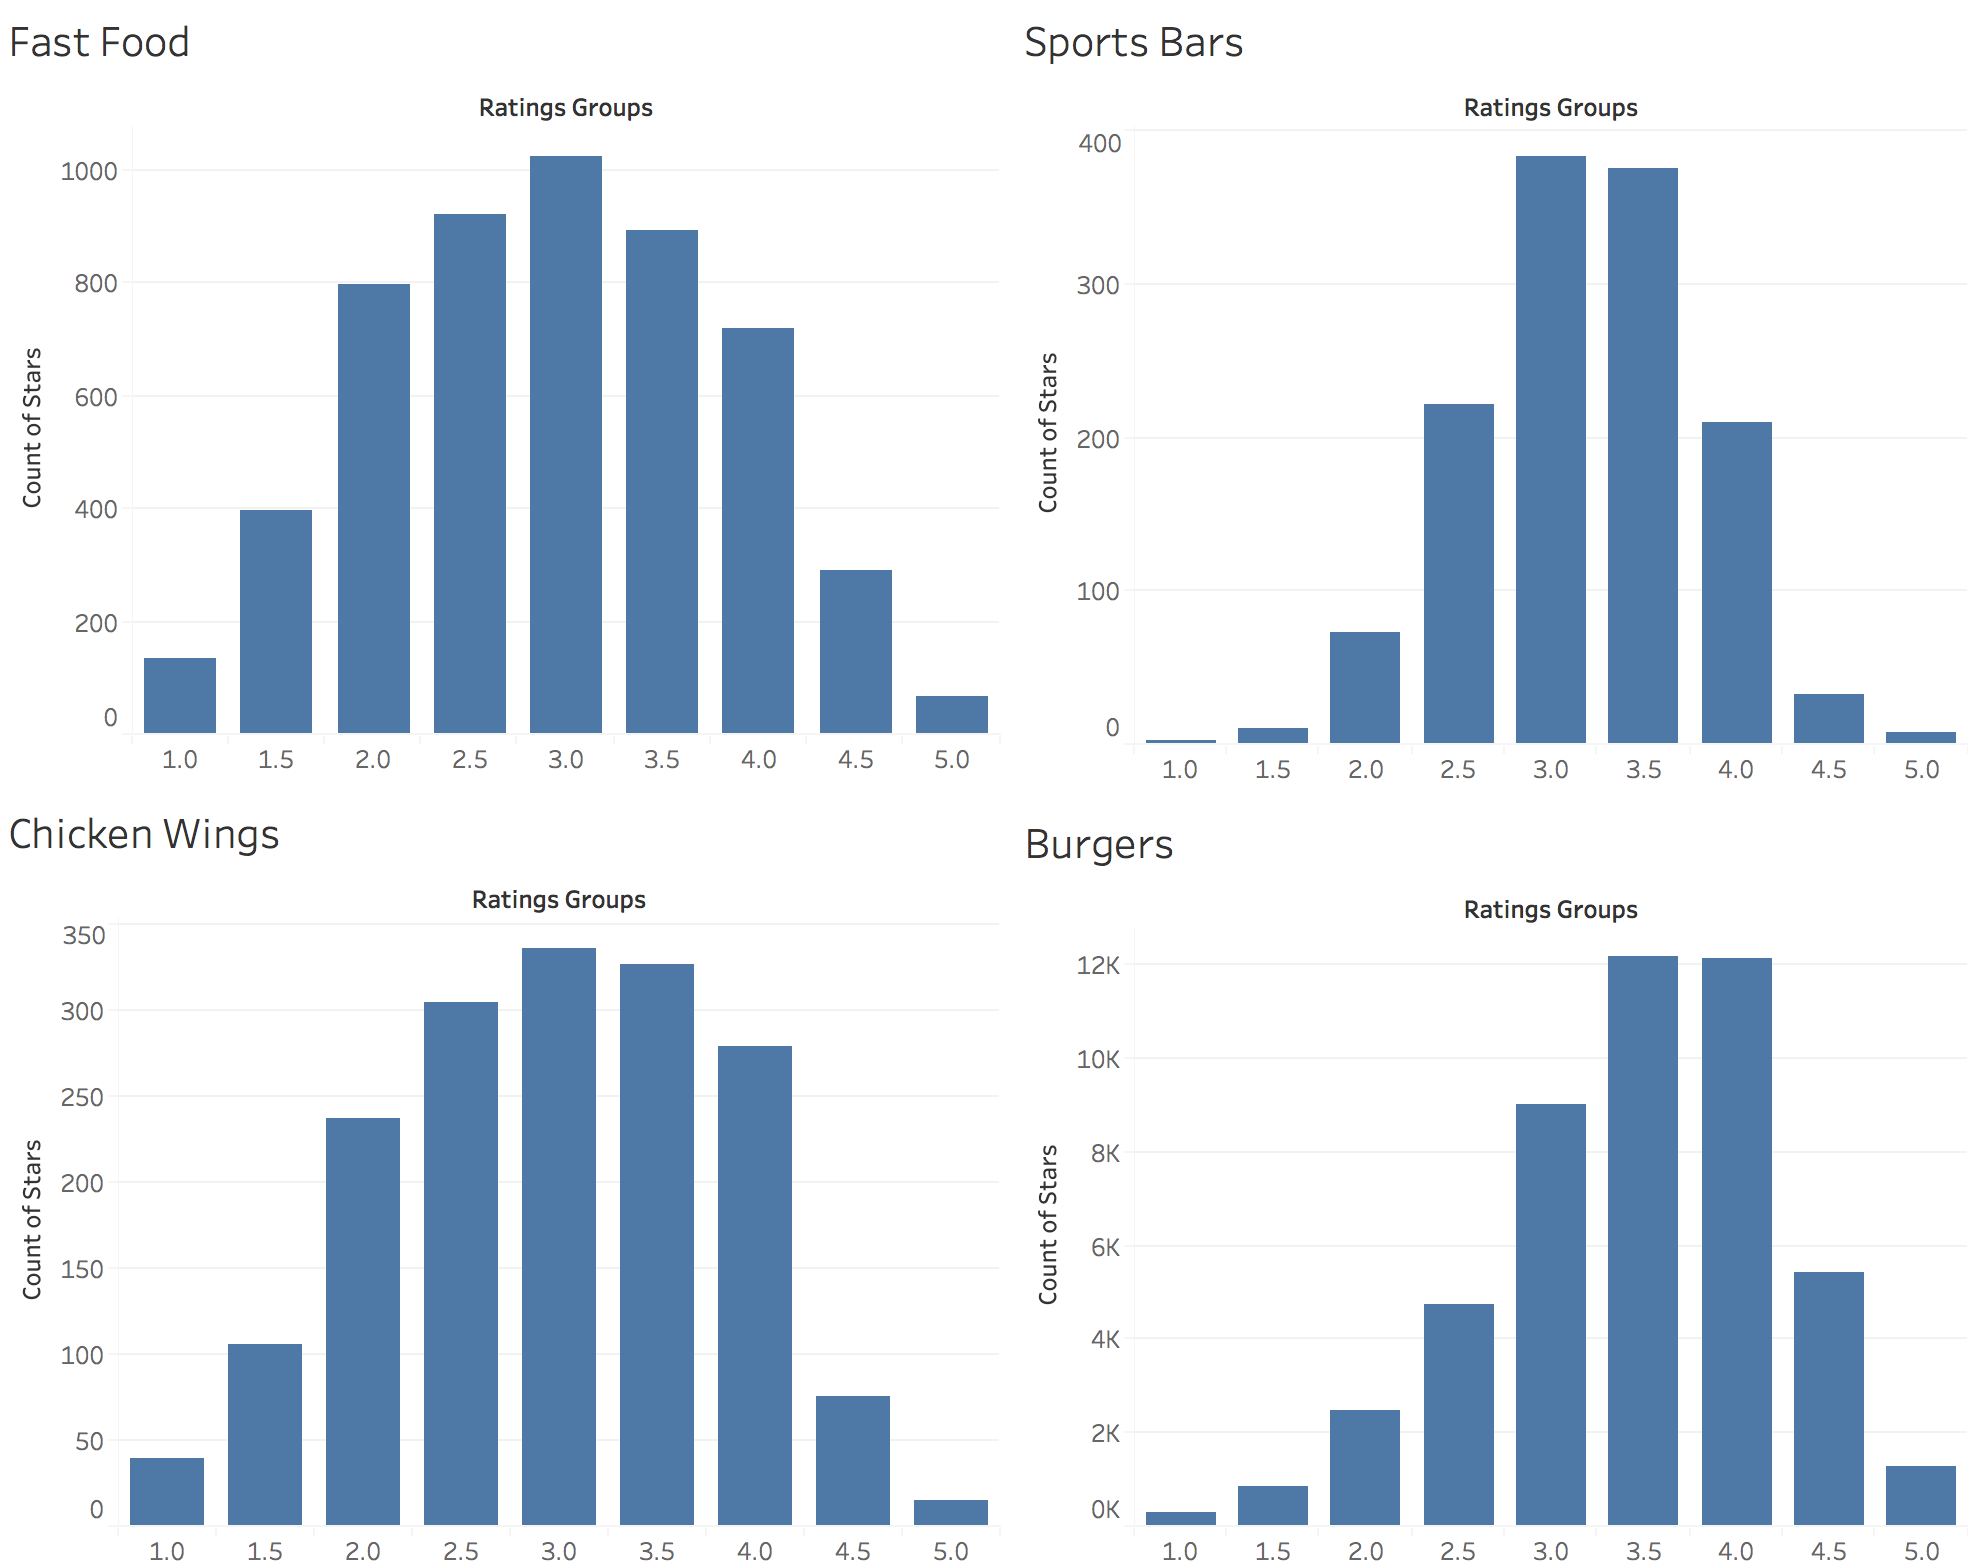

In [139]:
Image(filename="yelp/Low Rating Categories.png",width=700,height=500)


The shape for 3 of the 4 charts looks symmetric. Instead of centering around 3.5 to 4 stars, most of the distributions are center around 3 stars besides the burgers label. These shifts cause these labels to have the lowest rating among all categories. However, Sports Bar and Burgers have relatively lower number of 1 to 2 stars rating compare to the other 2 labels. This make sense since burgers is not a dish that's unique to fast food restaurants. There are many restaurants that make great burgers. Sports Bar has better ratings than Fast Food but only by a small margin. Sports bar's rowdiness and sub-par bar food probably contribute to low overall average rating. However, even with the 4 worst labels, most of the mass in these distribution is concentrated near the middle instead of near the lower rating range. 


### Category Labels with High Ratings

The following plot shows the distribution of restaurant ratings associated with high rating labels

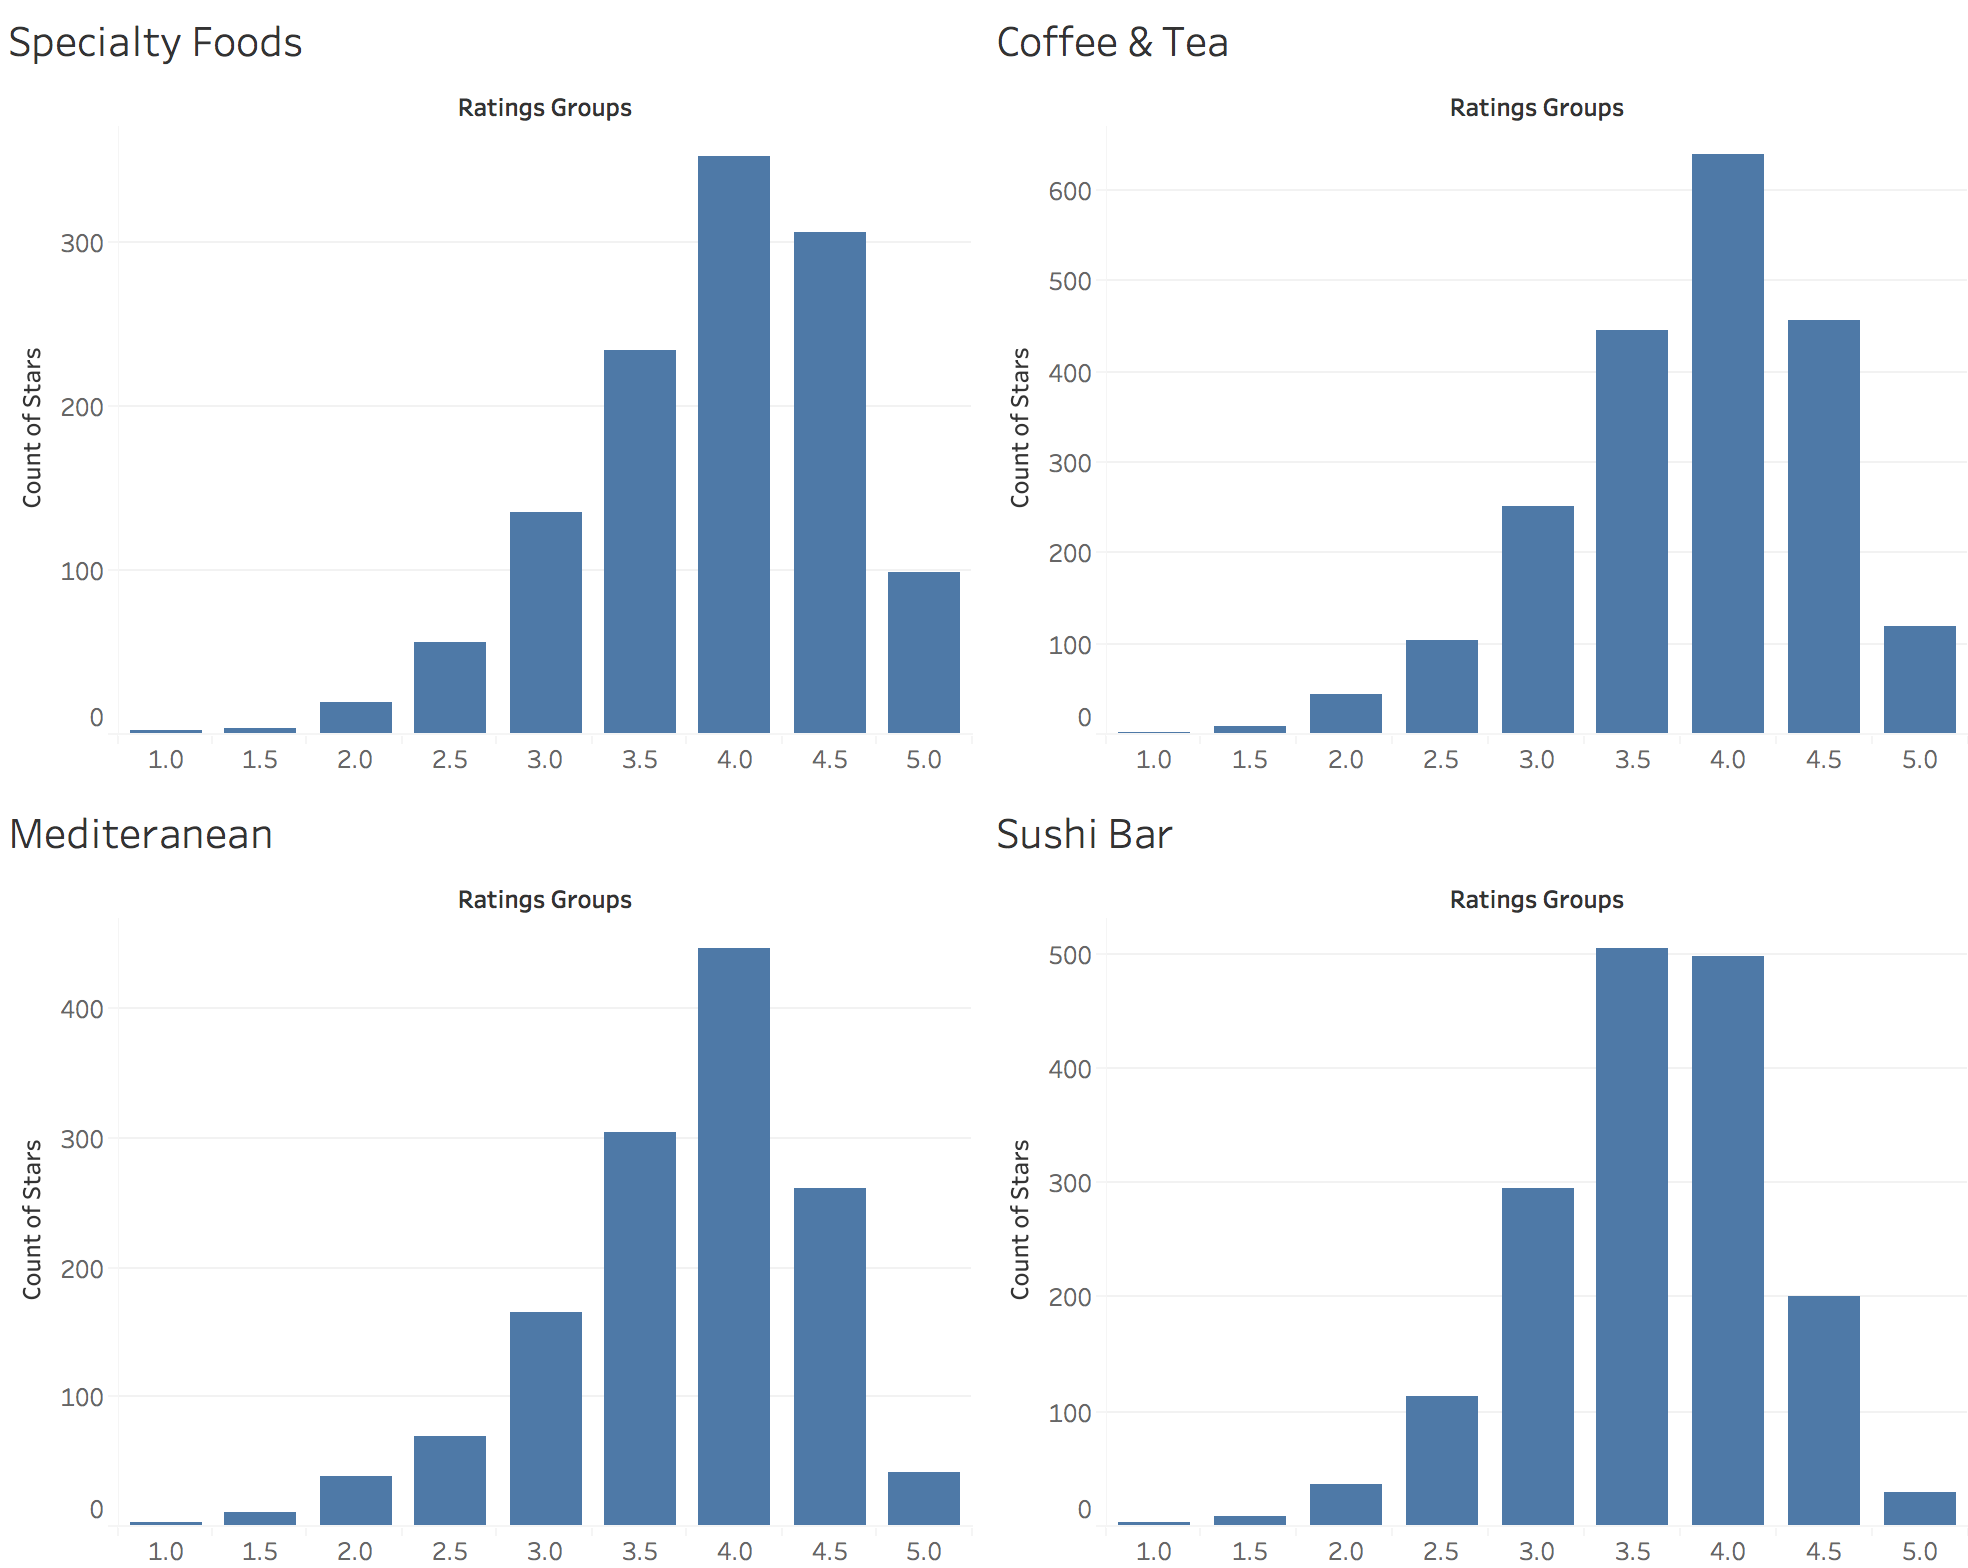

In [140]:
Image(filename="yelp/High Ratings Categories.png",width=700,height=500)


All 4 charts have a left-skewed distribution. For the labels with the highest average ratings, Specialty Foods and Coffee & Tea, a lot of the mass is concentrated on 4 and 4.5 stars. This pattern drives the average rating up, but the 5-star section is still relatively small compare to the other rating groups. Even if a category label is associated with high ratings, it's still rare for restaurants to maintain a near-perfect 5-star average rating. In terms of the type of cuisines, Mediterranean came out on top, followed by Sushi Bar. As mentioned earlier, grab-and-go places such as Coffee & Tea also has high average rating since it has less face-time with the customer. This supports the hypothesis that a high average rating does not necessarily imply a great experience, just not a bad experience.  


### Fancy Restaurants

One would expect fancy restaurants to receive high rating. What combination of features for a fancy restaurant are associated with high ratings? The following plot display the combine effects of 4 different attributes, Restaurants Attire, RSVP, Upscale, and Trendy on the ratings of restaurants.

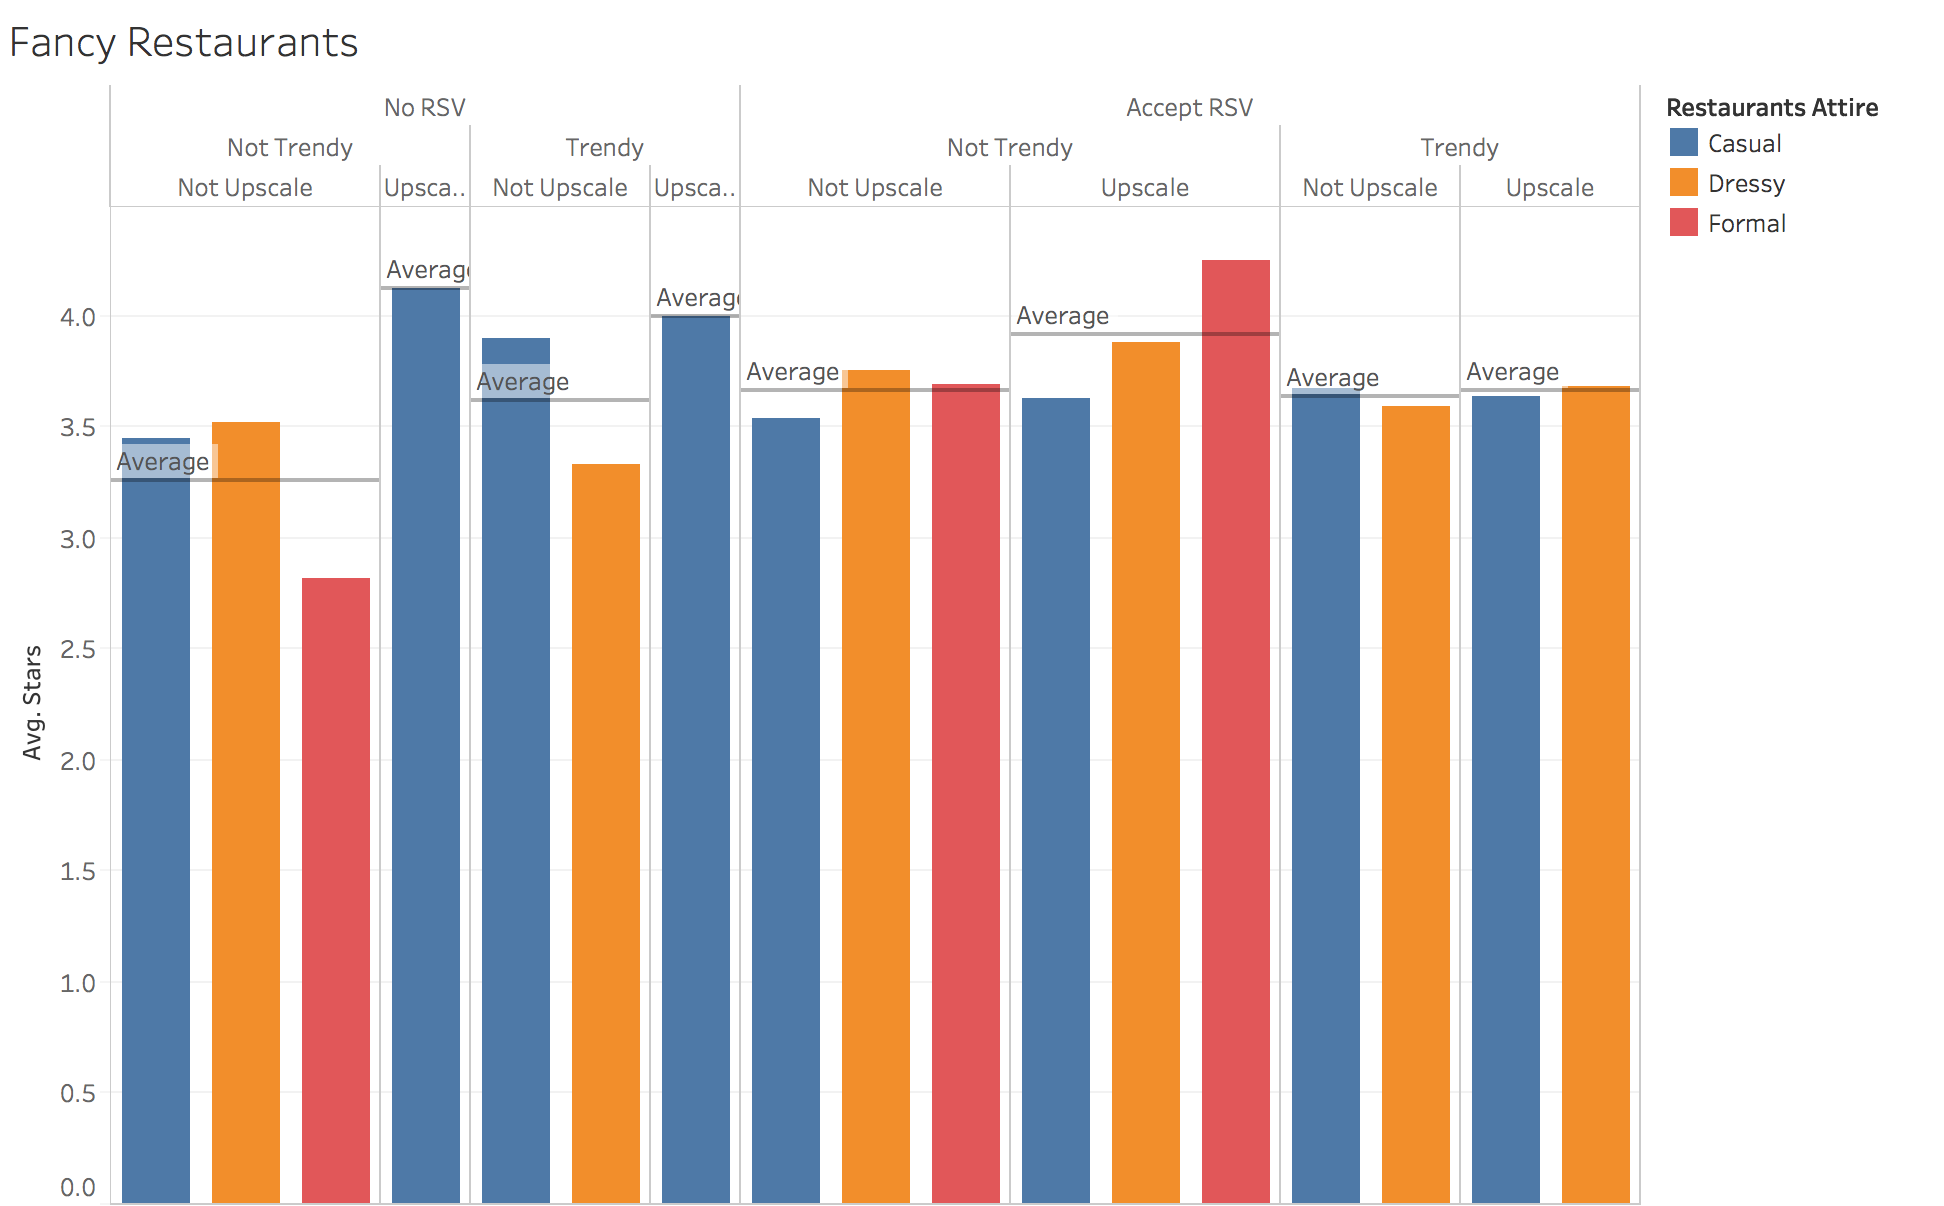

In [150]:
Image(filename="yelp/fancy.png",width=800,height=600)


Based on the chart, restaurants that are upscale, accept reservation, have formal dress code, but not trendy has the highest average rating of 4.2. Following this group, the other 2 combinations with higher ratings are under no reservation and casual dress code, but are still conisider upscale. The upscale attribute contributes to high ratings, while the other 3 attribute have varied effect depending on the specific combination.

### Restaurants Accommodation

Another question that may be of interest is what type of accommodation should a restaurant have to receive higher ratings. 4 relevant attributes, Good for Kids, Good For Groups, Outdoor Seating, and TV are plotted against the average ratings below.


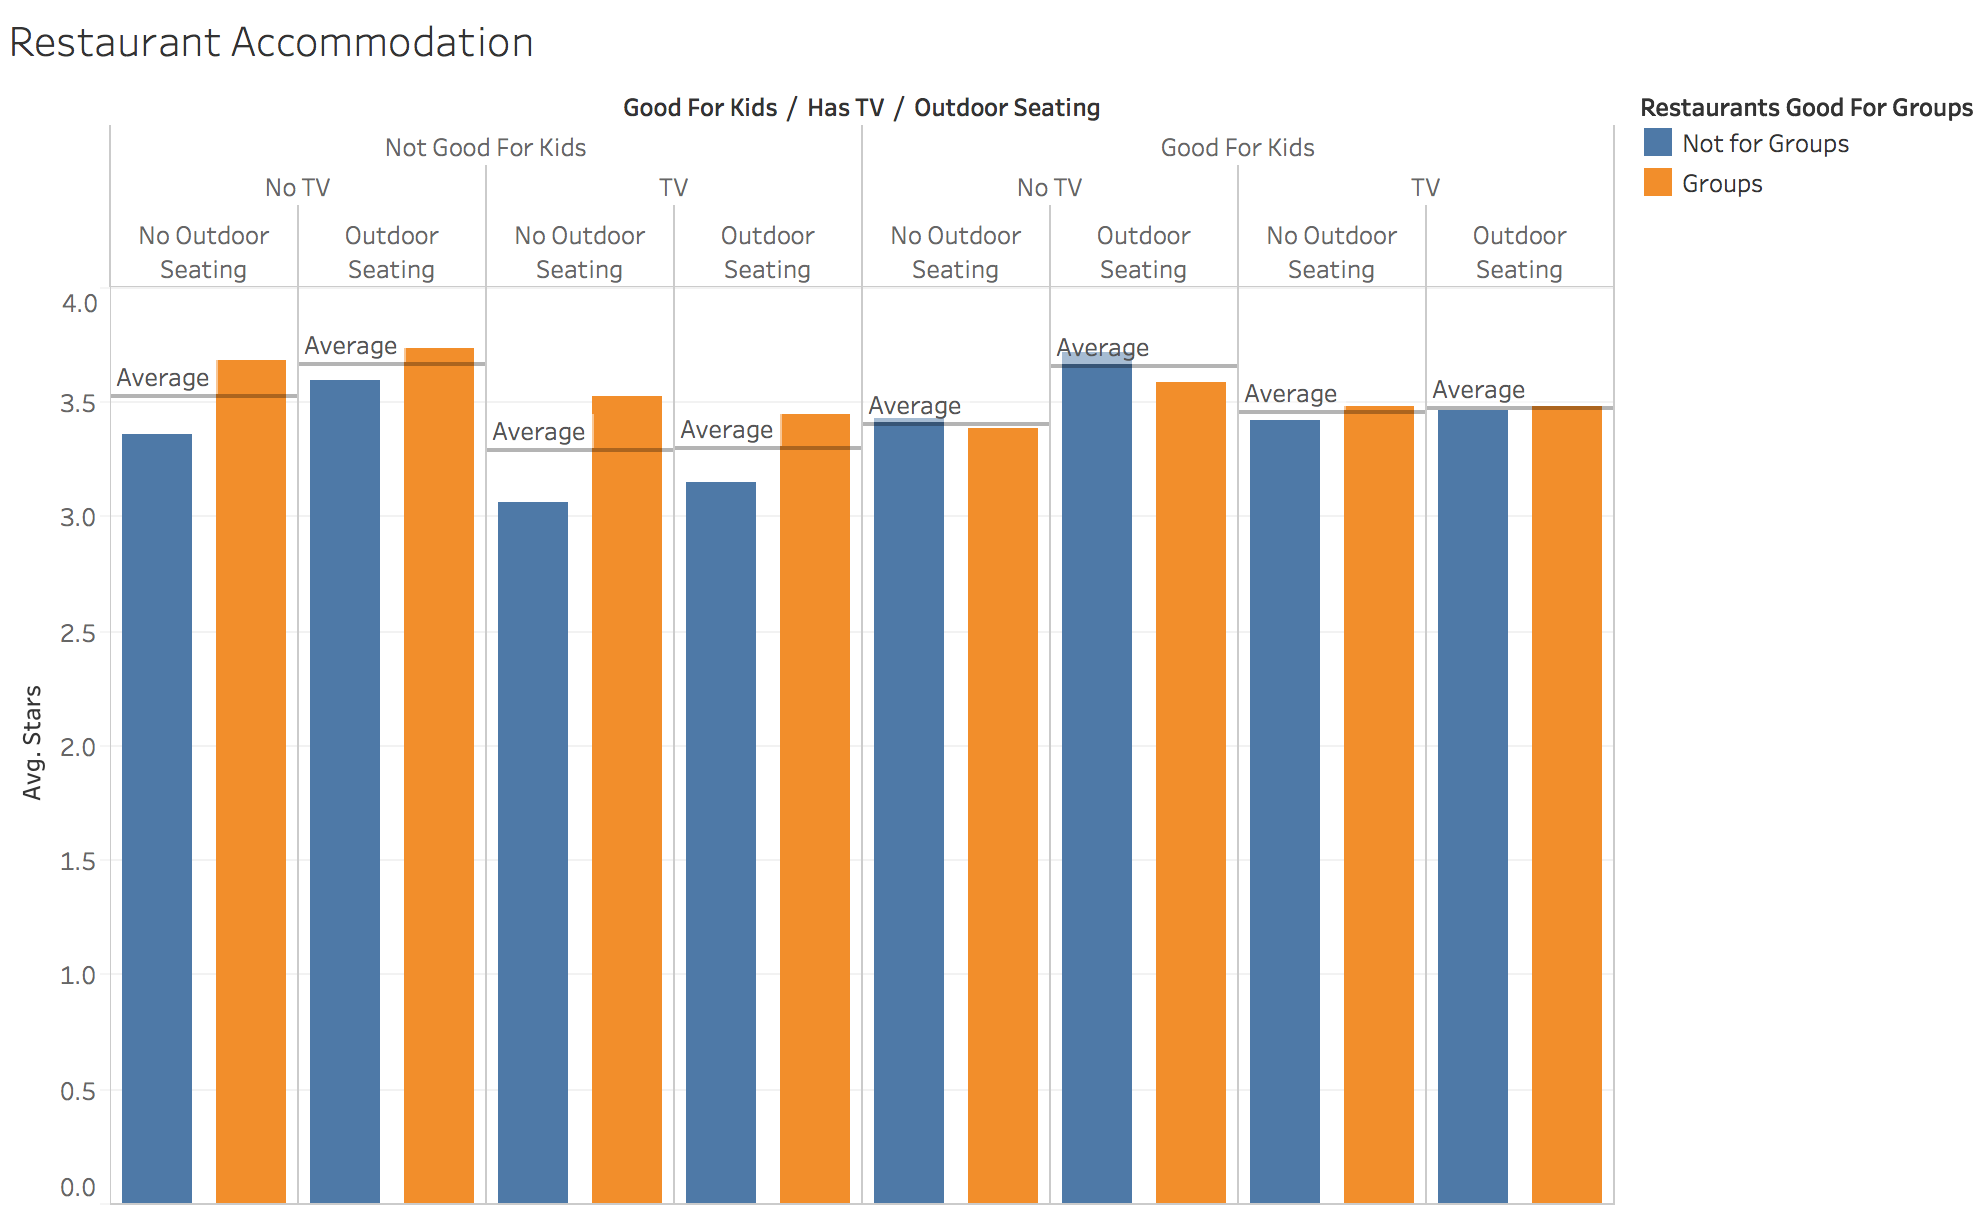

In [3]:
Image(filename="yelp/envir.png",width=850,height=650)

The difference among groups doesn't seem to be prevalent within the Good for Kids attribute. Since most reviews are probably writtne by adults, this is not surprising. For restaurants that are not good for kids, having outdoor seating and being good for groups leads to higher ratings. Having no TV also seem to improve customer experiene. Having a TV probably implies that the restaurant is a bar, or it just simply provides distraction to the entire dining experience.


### Going Out for a Drink

Besides providing dining experiences, restaurants also provide customers a venue to grab a drink on a Friday night or even music and clubbing experiences. The following plot explores the relationship between the category label nightlife, the attributes noise level and alcohol, and the average ratings among those groups.

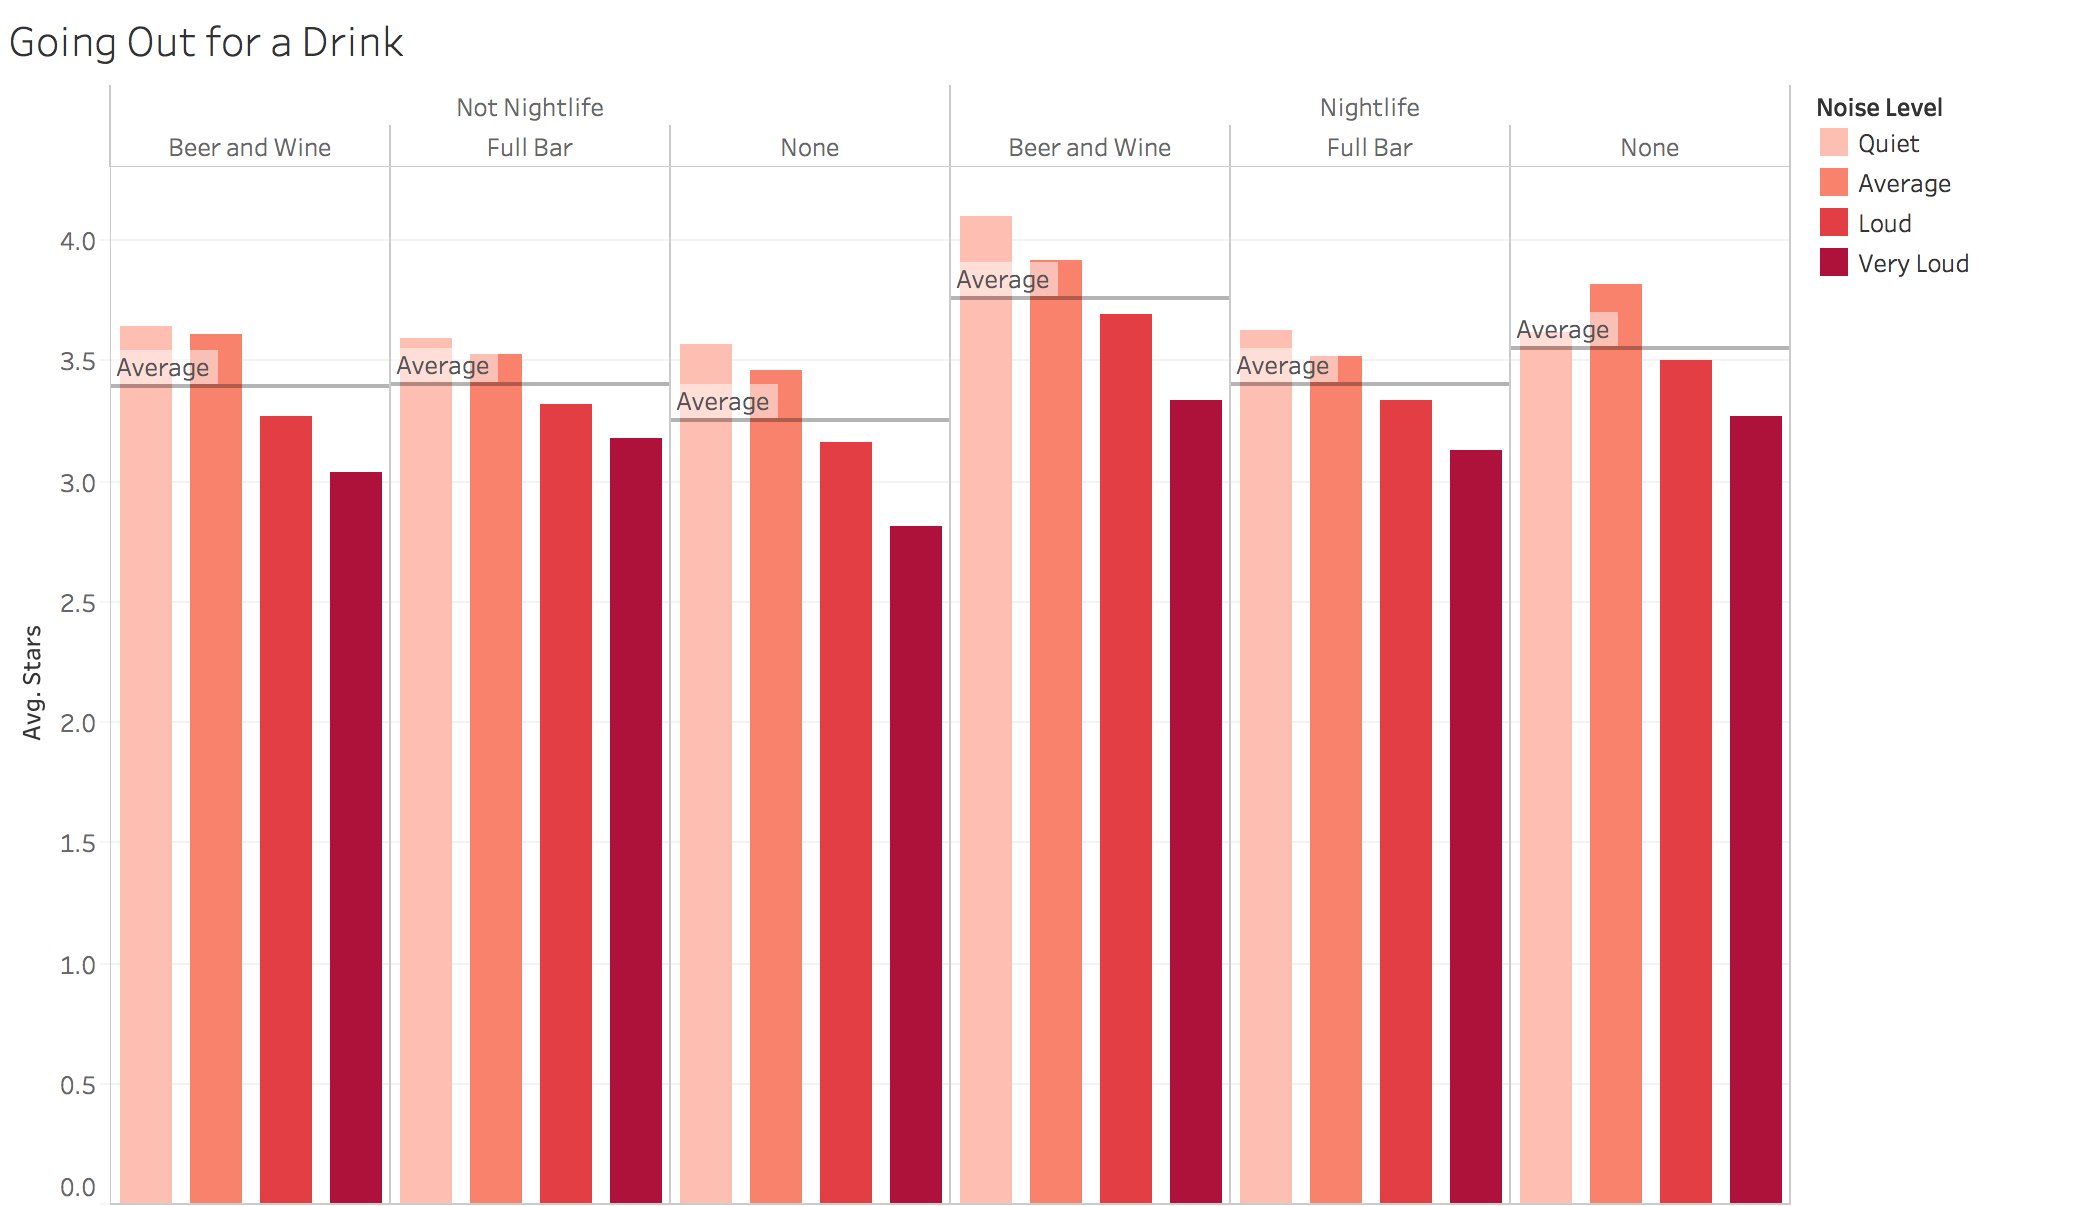

In [152]:
Image(filename="yelp/drink.png",width=800,height=600)


The first feature that follows a pretty strict pattern is Noise Level. Even among restaurants labeled with Nightlife, quiet noise level still has the highest average ratings. One would expect that place with average noise level would be more favorable. It's also interesting to see that there are restaurants with the Nightlife label but has the alcohol attribute of none. This maybe just data entry error. For the type of alcohol, beer and wine leads to the highest average review. This can be interpreted as that the restaurants with a specialty in beer and wine, and quiet noise level, provides the best customer experience.

### User Reviews Text Analytics 

In addition to the restaurant dataset, the review data set can also provide some insights into what recurring phrases appear across individual 5 star reviews or 1-2 star reviews. The original reviews data set is quite large, and not all of them are associated with a restaurant. The preprocessing steps are as follow:
- Parse reviews JSON file into Python
- Inner join the list of restaurants and the list of reviews to generate a list of restaurant reviews
- Sample 10,000 5 star reviews and 10,000 1/2 star reviews for text analytics
- Use Sklearn to vectorize the reviews with bag of words method and generate a list of the most common 2 word phrases

The code for this step is included in a separate python notebook (Review Processing).

### 5 Star Reviews Word Cloud

The following word cloud is generated from the most common 2 word phrases among 5 star reviews. Some phrases such as "good food" and "great service", which have high occurrence but provide little insight was removed. What remains are a combination of phrases that refer to the quality of the food, excellence in customer service, and reasonable pricing. Some of the more interesting phrases include "New York", "gluten free", "beer selection", and "worth wait".


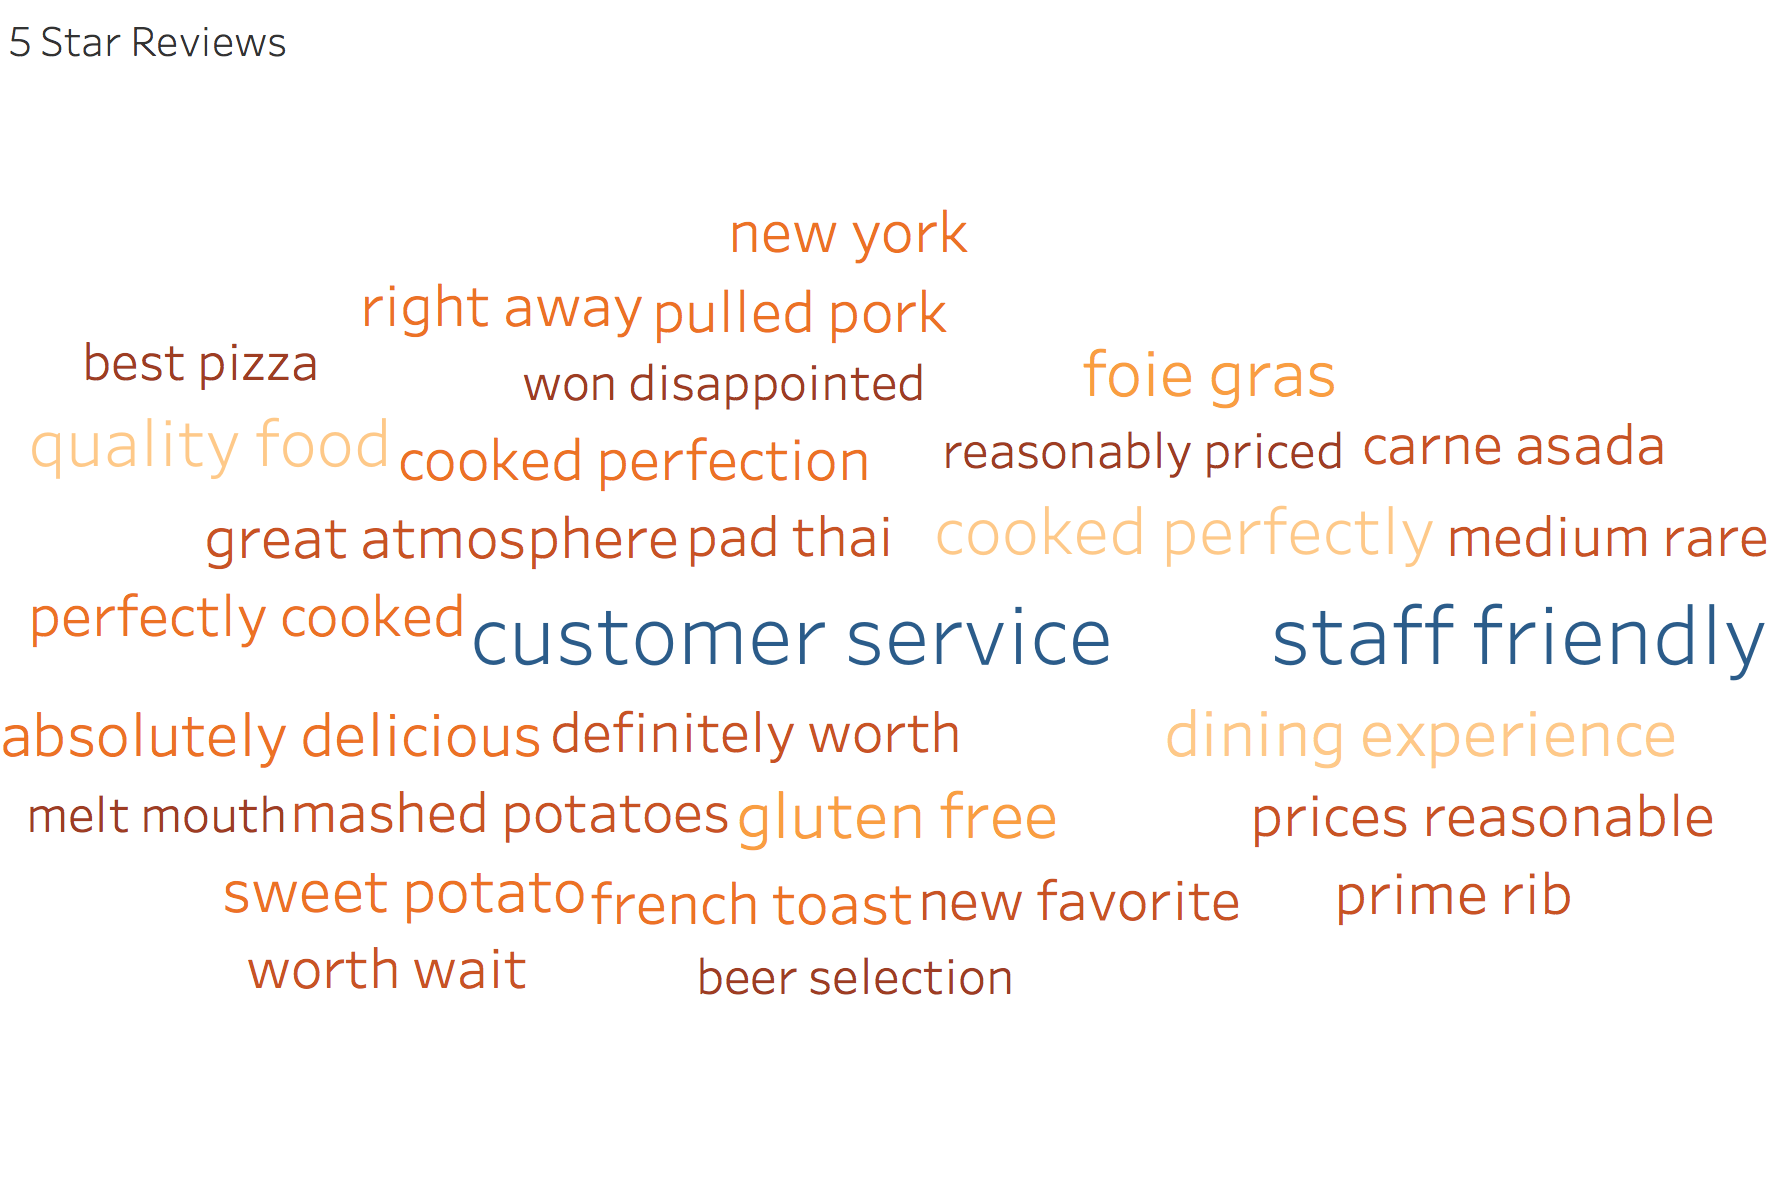

In [157]:
Image(filename="yelp/good cloud.png",width=600,height=400)

### 1-2 Stars Review Wolrd Cloud

The following word cloud is generated from the most common 2 word phrases among 1-2 star reviews. Some phrases such as "bad food" and "poor service", which have high occurrence but provide little insight was removed. The remaining phrases are associated with complaints about poor customer service, manager involvement, and long wait time. The most common phrase is “tasted like". If a customer use the phrase "tasted like", that probably means the food is not meeting expectation and it taste like something else. Other phrases such as "save money", "stay away", and "avoid place" also suggest that low star reviews not only complain about the restaurant, but also deter future customers from going.

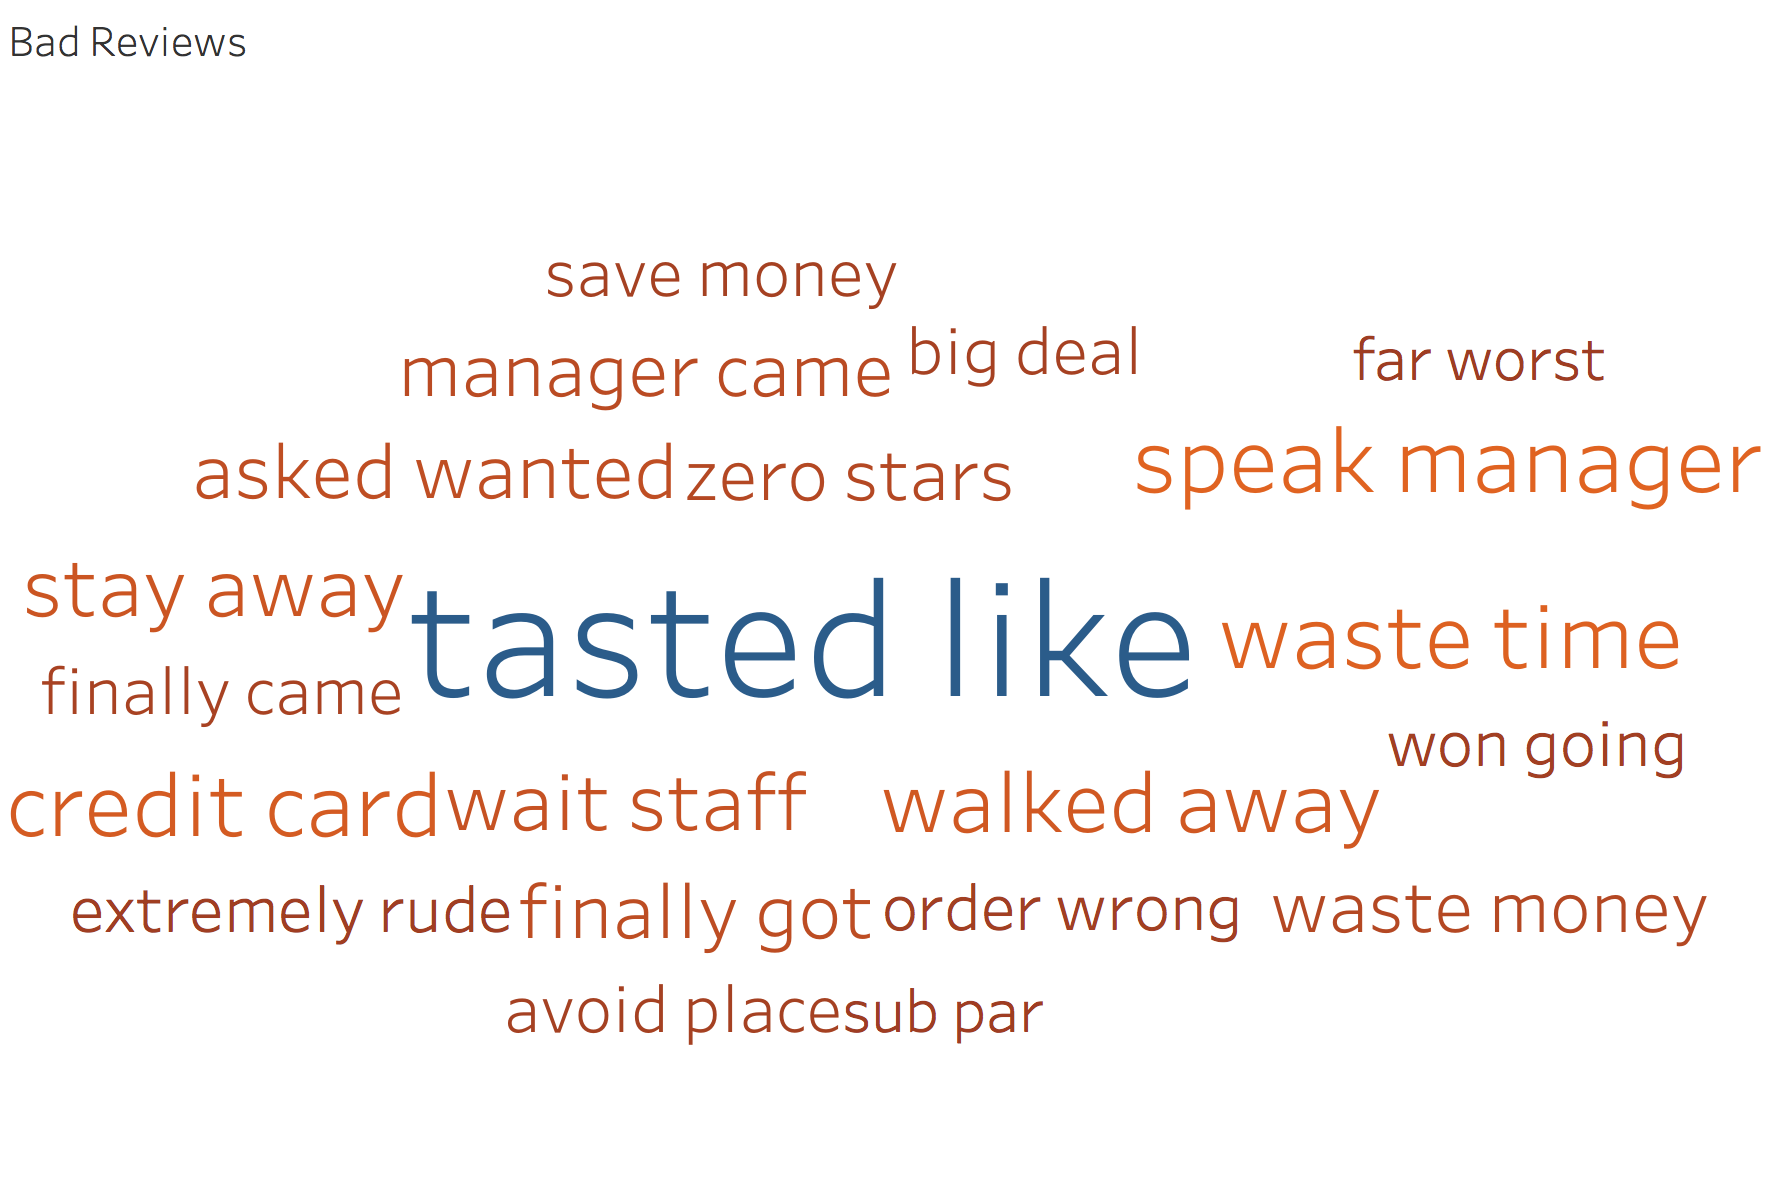

In [158]:
Image(filename="yelp/bad cloud.png",width=600,height=400)

## Conclusion

Given the vast amount of data and labels, answering the question what makes a restaurant have high Yelp ratings was not a simple task. It required a a good amount of data preprocessing on large data sets. A key field, affordability, or the dollar sign label was missing from a lot of the entries and could not be used. It would have been interesting to see how the price range of a restaurant affect its rating. This analysis by no means covered every single variable that factor into a high restaurant rating, but it could highlight some of the key variables that are associated with high ratings. In addition, just a simple analysis of the ratings themselves also offer insights into a somewhat flawed 5-Star rating system. 

Starting from just looking at the ratings distribution, the analysis show that an "above average" rating such as 4/5 is, in fact, not above average at all. While customers tend to give over positively reviews, it's still difficult to maintain a near 5-star average. (Average Ratings are rounded to the nearest .5 by default) It may be interesting to see what would happen if the rating system was switched to simply thumbs up or thumbs down. (This is the new Netflix rating system). This new system might encourage higher review counts, and a more conservative review of restaurant experiences. 

Analyzing the category labels gave some key insights, including some that are consistent with general expectation. Overall, restaurants that offer healthy food choices such and that are associated with better service receive higher ratings. On the other end, fast food restaurants have the lowest average rating. In addition to the type of food to serve, restaurants that have certain attributes are usually more favorable. These attributes include upscale ambience, having outdoor space, being good for groups, and maintaining a quiet noise level. At last, the word cloud revealed the common themes that make or break a customer's experience.

## Shortcomings

- The price data was not complete unfortunately. It would have added a lot of value to the analysis.
- There was no geographic analysis since the data was pulled from a selection of U.S. states. I wanted to blow up the New York City part but there was less than 20 retaurants from New York state itself. 
- The plots in this report were not that "diverse" compared to the plots we have went over in class. 
- The analysis with the plots is a bit lacking in depth, since I spent a more time on processing the data and pulling out good information.  

## Description of Submission Files

EDAV Project (Python Notebook) - The Final Report  
Reviews Processing (Python Notebook) - Code For Processing Reviews   
Yelp Folder - Includes png files of all Tableu graphs   